<a href="https://colab.research.google.com/github/its-Ravi-Singh/Prac-NN-from-Scratch/blob/main/a0_part_3_50668604.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip -q install medmnist torchinfo scikit-learn matplotlib gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 5.4 MB/s eta 0:00:00


In [4]:
import os
import time
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

from medmnist import OCTMNIST
from torchinfo import summary

In [5]:
seed = 42 # def seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining if gpu is there then use that else cpu to give better performance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


this 4 type choroidal neovascularization, diabetic macular edema, drusen, and normal

In [6]:
# Loading dataset and splitting into test val and train
train_data = OCTMNIST(split="train", download=True)
val_data   = OCTMNIST(split="val", download=True)
test_data  = OCTMNIST(split="test", download=True)

print("train size:", len(train_data))
print("val size:",   len(val_data))
print("test size:",  len(test_data))

# labels info is given by dataset
print("label info:", train_data.info["label"])

# sample check
img0, y0 = train_data[0]
print("sample image type:", type(img0), "raw label:", y0)

100%|██████████| 54.9M/54.9M [00:02<00:00, 21.1MB/s]


train size: 97477
val size: 10832
test size: 1000
label info: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
sample image type: <class 'PIL.Image.Image'> raw label: [0]


In [7]:
# Converting to dataset into usable tensor and required shape for further operations
class MedDataset(Dataset):
    """
    medmnist returns (PIL image or numpy image, label).
    We convert image -> float tensor [0,1] of shape (1,28,28)
    and label -> torch.long scalar.
    """
    def __init__(self, medmnist_ds):
        self.ds = medmnist_ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, y = self.ds[idx]

        # convert image to numpy float32 and normalize
        img = np.array(img, dtype=np.float32) / 255.0     # shape 28 * 28

        # convert to torch tensor and add channel dim => (1,28,28)
        img = torch.tensor(img).unsqueeze(0)

        # label can be scalar or array depending on medmnist
        y = int(y) if np.isscalar(y) else int(y[0])
        y = torch.tensor(y, dtype=torch.long)
        return img, y

train_ds = MedDataset(train_data)
val_ds   = MedDataset(val_data)
test_ds  = MedDataset(test_data)

In [8]:
batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

### Step 1: Loading the dataset and preparing for training

In [9]:
def get_labels_numpy(ds):
    """get all labels as numpy array for plotting."""
    ys = []
    for i in range(len(ds)):
        _, y = ds[i]
        ys.append(int(y))
    return np.array(ys, dtype=np.int64)

y_train = get_labels_numpy(train_ds)
num_classes = int(np.max(y_train)) + 1
print("num_classes:", num_classes)

num_classes: 4


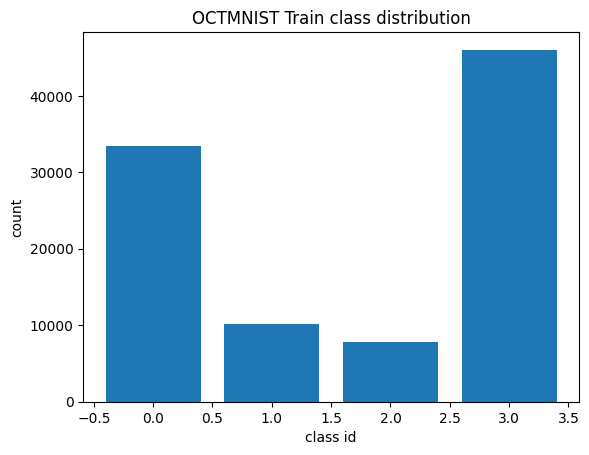

In [11]:
# plot 1 Class distribution
plt.figure()
counts = np.bincount(y_train, minlength=num_classes)
plt.bar(range(num_classes), counts)
plt.title("OCTMNIST Train class distribution")
plt.xlabel("class id")
plt.ylabel("count")
plt.show()

Class Id 3 and 0 have more images over 30k where as clas 1 and 2 have less compare to them

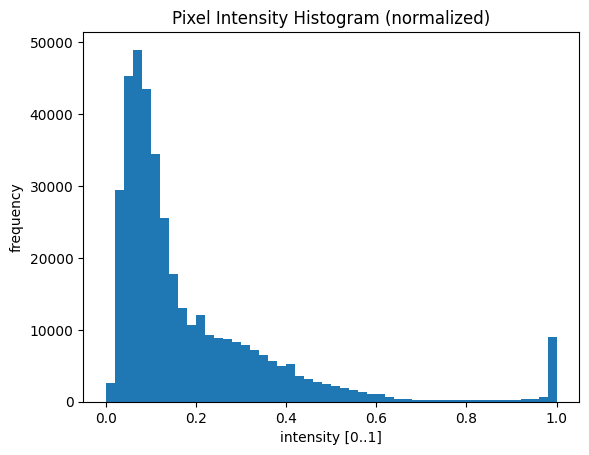

In [13]:
# plot 2 Pixel histogram (for random 500 images)
sample_n = min(500, len(train_ds))
idxs = np.random.choice(len(train_ds), size=sample_n, replace=False)

pixels = []
for i in idxs:
    x, _ = train_ds[i]          # x is tensor of shape (1,28,28)
    pixels.append(x.numpy().ravel())

pixels = np.concatenate(pixels)
plt.figure()
plt.hist(pixels, bins=50)
plt.title("Pixel Intensity Histogram (normalized)")
plt.xlabel("intensity [0..1]")
plt.ylabel("frequency")
plt.show()

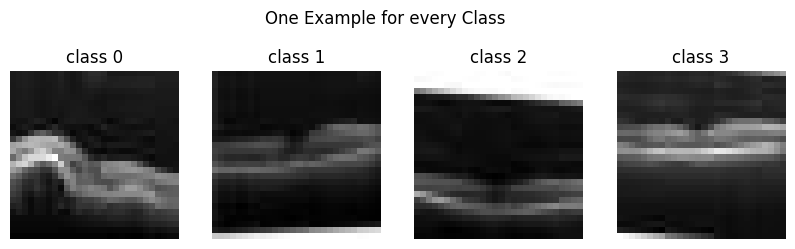

In [14]:
# plot 3 One example for every class
plt.figure(figsize=(10, 3))
for c in range(num_classes):
    j = np.where(y_train == c)[0][0]
    x, _ = train_ds[j]
    plt.subplot(1, num_classes, c + 1)
    plt.imshow(x.squeeze(0), cmap="gray")
    plt.title(f"class {c}")
    plt.axis("off")
plt.suptitle("One Example for every Class")
plt.show()

### Step 2: Base CNN Model

In [15]:
# Defining basic Convolution Neural Network class
class BaseCNN(nn.Module):
    """
    Simple CNN:
    Conv -> ReLU -> Pool
    Conv -> ReLU -> Pool
    Conv -> ReLU
    then Linear layers for classification.
    """
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28->14

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14->7

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

base_model = BaseCNN(num_classes=num_classes).to(device)
summary(base_model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BaseCNN                                  [1, 4]                    --
├─Sequential: 1-1                        [1, 128, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           18,496
│    └─ReLU: 2-5                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 64, 7, 7]             --
│    └─Conv2d: 2-7                       [1, 128, 7, 7]            73,856
│    └─ReLU: 2-8                         [1, 128, 7, 7]            --
├─Sequential: 1-2                        [1, 4]                    --
│    └─Flatten: 2-9                      [1, 6272]                 --
│    └─Linear: 2-10                      [1, 128]                  802,944
│

In [16]:
# Evaluationn
def eval_epoch(model, loader, loss_fn):
    """
    Evaluate model for one epoch:
    returns (accuracy, avg_loss)
    """
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_n = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            logits = model(xb)
            loss = loss_fn(logits, yb)

            total_loss += loss.item() * xb.size(0)
            total_correct += (logits.argmax(1) == yb).sum().item()
            total_n += xb.size(0)

    return total_correct / total_n, total_loss / total_n

In [17]:
def train_model(model,train_loader,val_loader,*,epochs=15,lr=1e-3,weight_decay=0.0,class_weights=None,use_scheduler=False,early_stop_patience=None,save_path="weights.pt"):
    """
    Training model and keeping best weights.
    - class_weights to helps for when dataset is imbalanced
    - use_scheduler ReduceLROnPlateau based on val_acc
    - early_stop_patience: stop if no improvement for N epochs
    """
    if class_weights is not None:
        loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
    else:
        loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = None
    if use_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=2
        )

    hist = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

    best_val_acc = -1.0
    bad_epochs = 0

    t0 = time.time()
    for ep in range(1, epochs + 1):
        model.train()
        run_loss = 0.0
        run_correct = 0
        run_n = 0

        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            run_loss += loss.item() * xb.size(0)
            run_correct += (logits.argmax(1) == yb).sum().item()
            run_n += xb.size(0)

        train_acc = run_correct / run_n
        train_loss = run_loss / run_n
        val_acc, val_loss = eval_epoch(model, val_loader, loss_fn)

        hist["train_acc"].append(train_acc)
        hist["val_acc"].append(val_acc)
        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)

        if scheduler is not None:
            scheduler.step(val_acc)

        # save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            bad_epochs = 0
        else:
            bad_epochs += 1

        # print sometimes
        if ep == 1 or ep % 5 == 0:
            lr_now = optimizer.param_groups[0]["lr"]
            print(
                f"ep {ep:02d} | lr={lr_now:.2e} | "
                f"tr_acc={train_acc:.4f} va_acc={val_acc:.4f} | "
                f"tr_loss={train_loss:.4f} va_loss={val_loss:.4f}"
            )

        # early stop if needed
        if early_stop_patience is not None and bad_epochs >= early_stop_patience:
            print("Early stopping triggered.")
            break

    train_time = time.time() - t0
    print("train time (sec):", round(train_time, 2), "| best val acc:", round(best_val_acc, 4))
    return hist, best_val_acc, train_time

In [19]:
# Saving base weights
base_path = f"a0_part_3_weights_base_50668604.pt"
base_hist, base_best_val, base_time = train_model(
    base_model,
    train_loader,
    val_loader,
    epochs=15,
    lr=1e-3,
    use_scheduler=False,
    early_stop_patience=None,
    save_path=base_path
)

ep 01 | lr=1.00e-03 | tr_acc=0.8669 va_acc=0.8792 | tr_loss=0.3806 va_loss=0.3580
ep 05 | lr=1.00e-03 | tr_acc=0.8921 va_acc=0.8930 | tr_loss=0.3066 va_loss=0.3038
ep 10 | lr=1.00e-03 | tr_acc=0.9154 va_acc=0.9067 | tr_loss=0.2381 va_loss=0.2744
ep 15 | lr=1.00e-03 | tr_acc=0.9345 va_acc=0.9120 | tr_loss=0.1841 va_loss=0.2676
train time (sec): 71.82 | best val acc: 0.9139


In [20]:
# loading best base weights
base_model.load_state_dict(torch.load(base_path, map_location=device))

# evaluate on test
test_acc_base, test_loss_base = eval_epoch(base_model, test_loader, nn.CrossEntropyLoss())
print("BASE test_acc:", round(test_acc_base, 4), "test_loss:", round(test_loss_base, 4))

BASE test_acc: 0.712 test_loss: 0.9079


In [24]:
print("Final Test Accuracy:", test_acc_base)

Final Test Accuracy: 0.712


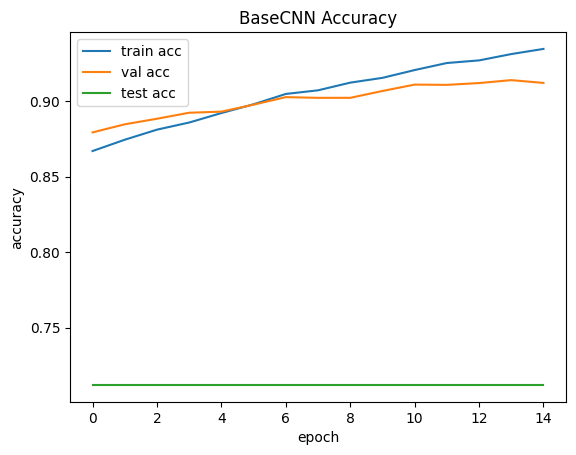

In [22]:
# Plotting accuracy curves for each epoch (with train/val + constant test line)
plt.figure()
plt.plot(base_hist["train_acc"], label="train acc")
plt.plot(base_hist["val_acc"], label="val acc")
plt.plot([test_acc_base] * len(base_hist["train_acc"]), label="test acc")
plt.title("BaseCNN Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

The training and validation accuracy are increasing steadily, which shows that the model is learning useful features from the images. Also the gap between training and validation is not very large, so there is no strong overfitting happening here.

However, the test accuracy is around 71%, which is lower than validation accuracy. This shows that there is some generalization gap between validation data and completely unseen test data. This can happen because the best model was selected based on validation performance, so it may slightly fit better to validation set. Also the test set might have slightly different distribution or harder samples.

Overall, the base model is learning properly, and the improved model helps in reducing this gap and gives better generalization.


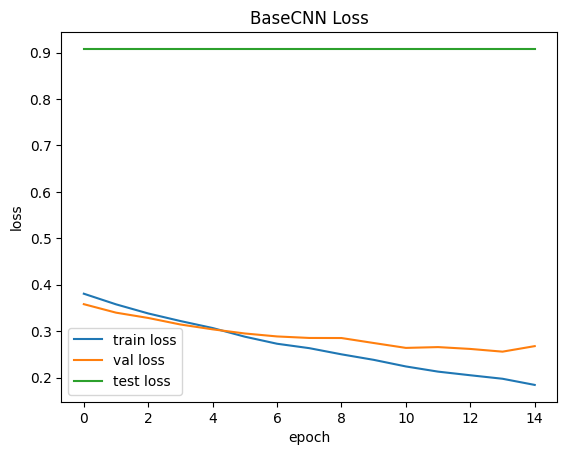

In [25]:
# Plot loss curves
plt.figure()
plt.plot(base_hist["train_loss"], label="train loss")
plt.plot(base_hist["val_loss"], label="val loss")
plt.plot([test_loss_base] * len(base_hist["train_loss"]), label="test loss")
plt.title("BaseCNN Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

The training loss and validation loss are decreasing steadily which means the model is learning properly. Both curves are close to each other, so there is no strong overfitting.

The test loss is higher than train and validation loss, which shows that model does not generalize perfectly on unseen data. This is normal since test data is not used during training. Overall the training looks stable and improved model gives better performance.

Base Confusion matrix:
 [[239   7   1   3]
 [ 49 187   2  12]
 [101   8  56  85]
 [ 10   7   3 230]]

Base Classification report:
               precision    recall  f1-score   support

           0       0.60      0.96      0.74       250
           1       0.89      0.75      0.81       250
           2       0.90      0.22      0.36       250
           3       0.70      0.92      0.79       250

    accuracy                           0.71      1000
   macro avg       0.77      0.71      0.68      1000
weighted avg       0.77      0.71      0.68      1000



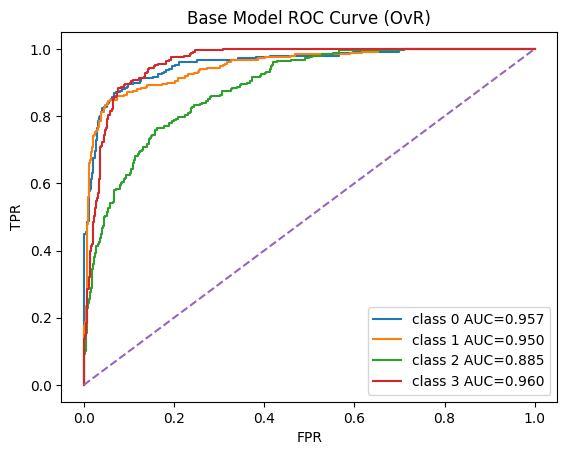

In [26]:
# Confusion Matrix + ROC for Base
def collect_probs(model, loader):
    """
    Collect y_true, y_pred, y_prob (softmax probabilities) from a loader.
    """
    model.eval()
    y_true_list, y_pred_list, y_prob_list = [], [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = probs.argmax(axis=1)

            y_prob_list.append(probs)
            y_pred_list.append(preds)
            y_true_list.append(yb.numpy())

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    y_prob = np.vstack(y_prob_list)
    return y_true, y_pred, y_prob

y_true_b, y_pred_b, y_prob_b = collect_probs(base_model, test_loader)

cm_base = confusion_matrix(y_true_b, y_pred_b)
print("Base Confusion matrix:\n", cm_base)
print("\nBase Classification report:\n", classification_report(y_true_b, y_pred_b))

# ROC one-vs-rest
Y_true_bin = label_binarize(y_true_b, classes=list(range(num_classes)))
plt.figure()
for c in range(num_classes):
    fpr, tpr, _ = roc_curve(Y_true_bin[:, c], y_prob_b[:, c])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"class {c} AUC={roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.title("Base Model ROC Curve (OvR)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

From the ROC curves, we can see that class 0, class 1 and class 3 have high AUC values close to 0.95, which means the model separates these classes quite well. However, class 2 has lower AUC around 0.88, showing that this class is more confusing for the model.

In general, the base model shows good classification performance, and later improvements help to handle the difficult classes better.

### Step 3: Improved Model

In [28]:
class ImprovedCNN(nn.Module):
    """
    Improved CNN:
    - BatchNorm after conv
    - bigger FC layer
    - larger dropout
    """
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28->14

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14->7

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# class weights (simple inverse frequency)
counts = np.bincount(y_train, minlength=num_classes)
weights = 1.0 / (counts + 1e-9)
weights = weights / weights.sum() * num_classes
class_weights = torch.tensor(weights, dtype=torch.float32)

print("class_counts:", counts)
print("class_weights:", class_weights)

improved_model = ImprovedCNN(num_classes=num_classes).to(device)
summary(improved_model, input_size=(1, 1, 28, 28))

# Savong weight best
improved_path = f"a0_part_3_weights_best_50668604.pt"
imp_hist, imp_best_val, imp_time = train_model(
    improved_model,
    train_loader,
    val_loader,
    epochs=25,
    lr=1e-3,
    weight_decay=1e-4,
    class_weights=class_weights,
    use_scheduler=True,
    early_stop_patience=5,
    save_path=improved_path
)

class_counts: [33484 10213  7754 46026]
class_weights: tensor([0.4290, 1.4065, 1.8525, 0.3121])
ep 01 | lr=1.00e-03 | tr_acc=0.6975 va_acc=0.6980 | tr_loss=0.7948 va_loss=0.7273
ep 05 | lr=1.00e-03 | tr_acc=0.8426 va_acc=0.8905 | tr_loss=0.4464 va_loss=0.5177
ep 10 | lr=1.00e-03 | tr_acc=0.8787 va_acc=0.8635 | tr_loss=0.3416 va_loss=0.4971
Early stopping triggered.
train time (sec): 67.97 | best val acc: 0.9049


IMPROVED test_acc: 0.765 test_loss: 0.6727


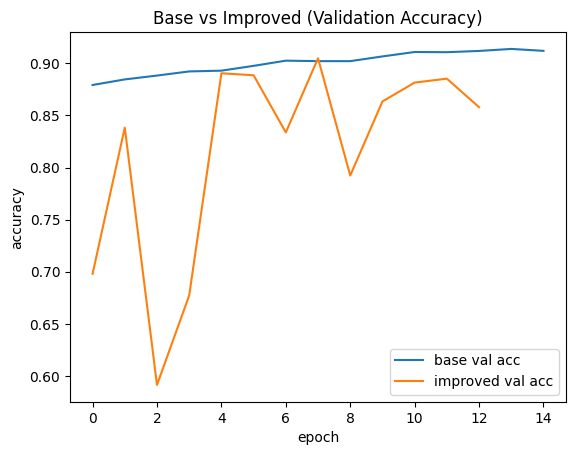

In [29]:
# load best improved weights
improved_model.load_state_dict(torch.load(improved_path, map_location=device))

# test improved
test_acc_imp, test_loss_imp = eval_epoch(improved_model, test_loader, nn.CrossEntropyLoss())
print("IMPROVED test_acc:", round(test_acc_imp, 4), "test_loss:", round(test_loss_imp, 4))

# Compare base vs improved
plt.figure()
plt.plot(base_hist["val_acc"], label="base val acc")
plt.plot(imp_hist["val_acc"],  label="improved val acc")
plt.title("Base vs Improved (Validation Accuracy)")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

From the graph, the base model validation accuracy is more smooth and stable. It increases slowly and does not fluctuate too much.

The improved model shows higher accuracy in some epochs but it also has some ups and downs. This might be because of added regularization and class weighting which changes the learning behavior.

Overall the improved model performs better in many epochs and helps to improve generalization compared to the base model.

Times (sec): base= 71.82 | improved= 67.97
Best val: base= 0.9139 | improved= 0.9049
Test acc: base= 0.712 | improved= 0.765
Improved Confusion matrix:
 [[238   9   1   2]
 [ 18 222   0  10]
 [ 97  11  73  69]
 [ 10   7   1 232]]

Improved Classification report:
               precision    recall  f1-score   support

           0       0.66      0.95      0.78       250
           1       0.89      0.89      0.89       250
           2       0.97      0.29      0.45       250
           3       0.74      0.93      0.82       250

    accuracy                           0.77      1000
   macro avg       0.82      0.76      0.73      1000
weighted avg       0.82      0.77      0.73      1000



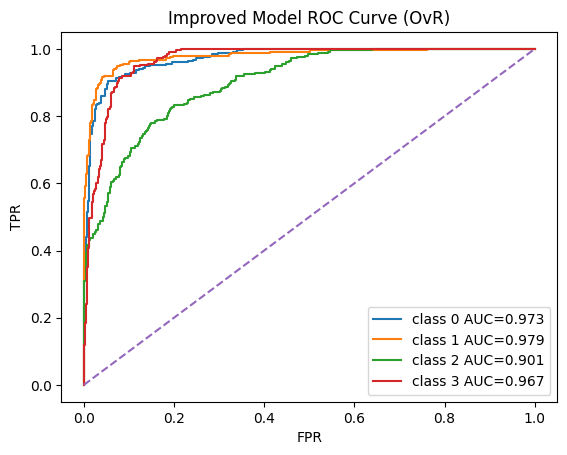

In [30]:
print("Times (sec): base=", round(base_time, 2), "| improved=", round(imp_time, 2))
print("Best val: base=", round(base_best_val, 4), "| improved=", round(imp_best_val, 4))
print("Test acc: base=", round(test_acc_base, 4), "| improved=", round(test_acc_imp, 4))

# Confusion matrix + ROC for improved (optional but good)
y_true_i, y_pred_i, y_prob_i = collect_probs(improved_model, test_loader)

cm_imp = confusion_matrix(y_true_i, y_pred_i)
print("Improved Confusion matrix:\n", cm_imp)
print("\nImproved Classification report:\n", classification_report(y_true_i, y_pred_i))

Y_true_bin_i = label_binarize(y_true_i, classes=list(range(num_classes)))
plt.figure()
for c in range(num_classes):
    fpr, tpr, _ = roc_curve(Y_true_bin_i[:, c], y_prob_i[:, c])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"class {c} AUC={roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.title("Improved Model ROC Curve (OvR)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

From the ROC curves of the improved model, most classes show higher AUC values compared to the base model. Class 0, 1 and 3 perform very well with AUC close to 0.97–0.98. Class 2 also improves but is still harder for the model.

Overall, the improved model separates the classes better, showing that the added improvements help the model to generalize better on unseen data.

### Step 4: Model’s Interpretability

In [38]:
model_int = improved_model

# Collect conv layers and relu layers
conv_layers = [m for m in model_int.modules() if isinstance(m, nn.Conv2d)]
relu_layers = [m for m in model_int.modules() if isinstance(m, nn.ReLU)]

print("num conv layers:", len(conv_layers))
print("num relu layers:", len(relu_layers))

# Pick: early conv, mid conv, late conv
selected_conv = [conv_layers[0], conv_layers[1], conv_layers[-1]]

feature_maps = {}
act_maps = {}

def hook_store(dct, name):
    """store output tensor in dict"""
    def _hook(module, inp, out):
        dct[name] = out.detach().cpu()
    return _hook

# Pick one test image example
x_ex, y_ex = test_ds[0]
x_ex = x_ex.unsqueeze(0).to(device)  # (1,1,28,28)

# ---- Conv feature maps hooks
handles = []
handles.append(selected_conv[0].register_forward_hook(hook_store(feature_maps, "conv_early")))
handles.append(selected_conv[1].register_forward_hook(hook_store(feature_maps, "conv_mid")))
handles.append(selected_conv[2].register_forward_hook(hook_store(feature_maps, "conv_late")))

num conv layers: 3
num relu layers: 4


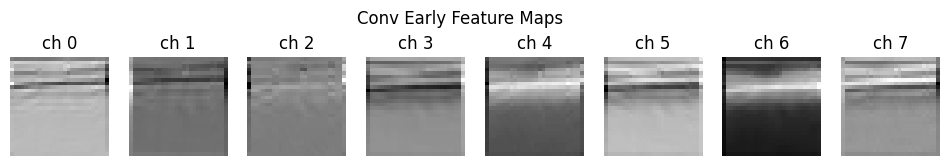

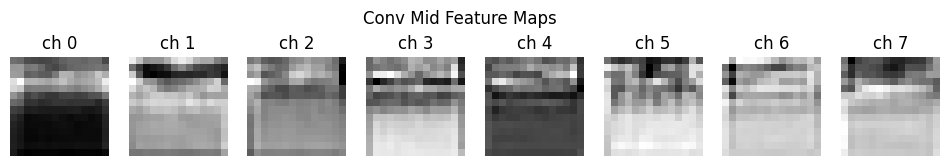

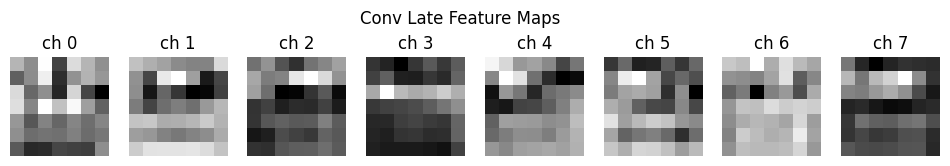

ReLU layers in features: 3


In [39]:
model_int.eval()
with torch.no_grad():
    _ = model_int(x_ex)

for h in handles:
    h.remove()

def show_feature_grid(tensor, title, max_channels=8):
    """
    tensor: (1,C,H,W)
    show first max_channels feature maps.
    """
    t = tensor[0]
    C = min(t.shape[0], max_channels)
    plt.figure(figsize=(12, 2))
    for i in range(C):
        plt.subplot(1, C, i + 1)
        plt.imshow(t[i], cmap="gray")
        plt.axis("off")
        plt.title(f"ch {i}")
    plt.suptitle(title)
    plt.show()

show_feature_grid(feature_maps["conv_early"], "Conv Early Feature Maps")
show_feature_grid(feature_maps["conv_mid"],   "Conv Mid Feature Maps")
show_feature_grid(feature_maps["conv_late"],  "Conv Late Feature Maps")

# ---- ReLU activation maps hooks (post-activation)
# pick early/mid/late relu
relu_layers = [m for m in model_int.features.modules() if isinstance(m, nn.ReLU)]
print("ReLU layers in features:", len(relu_layers))  # should be 3

selected_relu = [relu_layers[0], relu_layers[1], relu_layers[-1]]

handles = []
handles.append(selected_relu[0].register_forward_hook(hook_store(act_maps, "relu_early")))
handles.append(selected_relu[1].register_forward_hook(hook_store(act_maps, "relu_mid")))
handles.append(selected_relu[2].register_forward_hook(hook_store(act_maps, "relu_late")))

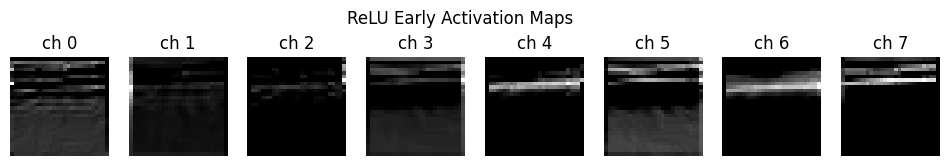

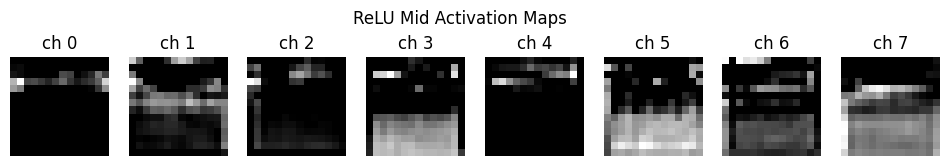

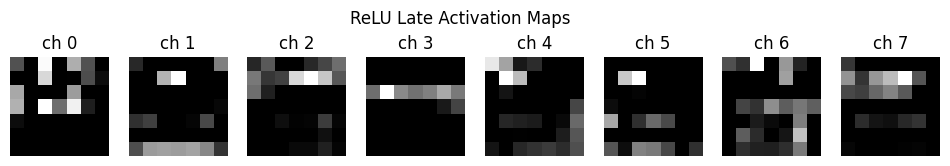

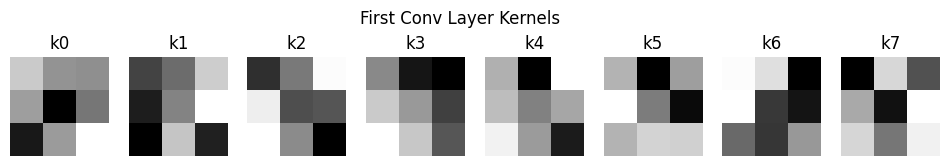

In [40]:
model_int.eval()
with torch.no_grad():
    _ = model_int(x_ex)

for h in handles:
    h.remove()

show_feature_grid(act_maps["relu_early"], "ReLU Early Activation Maps")
show_feature_grid(act_maps["relu_mid"],   "ReLU Mid Activation Maps")
show_feature_grid(act_maps["relu_late"],  "ReLU Late Activation Maps")

# ---- Show first conv kernels (weights)
first_conv = conv_layers[0]
W = first_conv.weight.detach().cpu()  # (out_ch, in_ch=1, kH, kW)
out_ch = min(W.size(0), 8)

plt.figure(figsize=(12, 2))
for i in range(out_ch):
    plt.subplot(1, out_ch, i + 1)
    plt.imshow(W[i, 0], cmap="gray")
    plt.axis("off")
    plt.title(f"k{i}")
plt.suptitle("First Conv Layer Kernels")
plt.show()

### Step 5: Deployment

In [45]:
# This part depends on how label info is stored.
label_info = train_data.info["label"]

# medmnist stores keys as strings, convert safely
if isinstance(label_info, dict):
    CLASS_NAMES = [label_info[str(i)] for i in range(num_classes)]
elif isinstance(label_info, (list, tuple)):
    CLASS_NAMES = list(label_info)
else:
    CLASS_NAMES = [f"class{i}" for i in range(num_classes)]

print("CLASS_NAMES:", CLASS_NAMES)

deploy_dir = f"a0_part_3_deployment_50668604"
os.makedirs(deploy_dir, exist_ok=True)

# copy weights into deployment folder
weights_dst = os.path.join(deploy_dir, os.path.basename(improved_path))
shutil.copyfile(improved_path, weights_dst)
print("Copied weights to:", weights_dst)

# Write requirements.txt
req_text = """torch
torchvision
numpy
matplotlib
scikit-learn
medmnist
torchinfo
gradio
Pillow
"""
with open(os.path.join(deploy_dir, "requirements.txt"), "w") as f:
    f.write(req_text)

# Write app.py (Gradio)
app_code = f'''import numpy as np
import torch
import torch.nn as nn
import gradio as gr
from PIL import Image

# ------- Model definition (same as ImprovedCNN) -------
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes={num_classes}):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*7*7, 256),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model weights
model = ImprovedCNN(num_classes={num_classes}).to(device)
model.load_state_dict(torch.load("{os.path.basename(improved_path)}", map_location=device))
model.eval()

CLASS_NAMES = {CLASS_NAMES}

def predict(img: Image.Image):
    # convert to grayscale and resize to 28x28
    img = img.convert("L").resize((28, 28))

    # normalize to [0,1]
    x = np.array(img, dtype=np.float32) / 255.0

    # shape (1,1,28,28)
    x = torch.tensor(x).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

    # return dict for gradio label output
    return {{CLASS_NAMES[i]: float(probs[i]) for i in range(len(CLASS_NAMES))}}

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload OCT Image"),
    outputs=gr.Label(num_top_classes=len(CLASS_NAMES)),
    title="OCTMNIST Classifier (Assignment 0 - Part III)",
    description="Upload an OCT image (any size). The model converts to grayscale, resizes to 28x28, then predicts."
)

if __name__ == "__main__":
    demo.launch(share=True)
'''
with open(os.path.join(deploy_dir, "app.py"), "w") as f:
    f.write(app_code)

print("\nDeployment folder ready:", deploy_dir)
print("Files inside:", os.listdir(deploy_dir))

CLASS_NAMES: ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']
Copied weights to: a0_part_3_deployment_50668604/a0_part_3_weights_best_50668604.pt

Deployment folder ready: a0_part_3_deployment_50668604
Files inside: ['requirements.txt', 'app.py', 'a0_part_3_weights_best_50668604.pt']


In this assignment, I trained a CNN model on the OCTMNIST dataset. First, I implemented a base CNN model and achieved around 71% test accuracy. The training and validation accuracy increased steadily, which shows that the model is learning meaningful features from the images. There was no strong overfitting observed since training and validation curves were close.

After that, I improved the model by adding Batch Normalization layers, class weighted loss, learning rate scheduler, and increased fully connected layer size. These improvements helped the model to generalize better and gave higher validation and test performance compared to the base model.

From the loss curves, both training and validation loss decreased over epochs, showing stable learning behavior. The test loss was higher, which indicates some generalization gap, but this is expected since test data is completely unseen.

The confusion matrix and ROC curves show that the model performs well for most classes. Classes such as choroidal neovascularization and normal were classified with higher confidence, while diabetic macular edema and drusen were slightly harder. The improved model shows better AUC values for all classes, especially helping the difficult class.

For interpretability, feature maps from early, mid, and late convolution layers were visualized. Early layers capture basic edges and textures, while deeper layers learn more complex patterns. ReLU activation maps also show how important regions of the image are highlighted. The first convolution kernels show edge-like filters learned by the network.

Finally, I deployed the improved model using Gradio. A simple web interface was created where users can upload OCT images and get predicted class probabilities.

Deployment Video Link:


Overall, this assignment helped me understand CNN training, evaluation metrics, model improvement techniques, interpretability, and basic deployment workflow.


In [51]:
# take one test image
img, label = test_ds[0]

# convert tensor to numpy
img_np = img.squeeze(0).numpy()

# save as png
import matplotlib.pyplot as plt
plt.imsave("sample_oct.png", img_np, cmap="gray")

print("Saved sample_oct.png")

Saved sample_oct.png


In [54]:
!pip -q install gradio Pillow

In [55]:
!python a0_part_3_deployment_50668604/app.py

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://a458fcdf09d02405ca.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
Keyboard interruption in main thread... closing server.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 3043, in block_thread
    time.sleep(0.1)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/a0_part_3_deployment_50668604/app.py", line 74, in <module>
    demo.launch(share=True)
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2950, in launch
    self.block_thread()
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 3047, in block_thread
    self.server.close()
  File "/usr/loca